In [1]:
import numpy as np
import fiducial as fid
import matplotlib.pyplot as plt
import utils as u
import Eg_cov as egcov
import pyccl.nl_pt as pt

This notebook gets the linear scale cuts when we implement a correction for nonlinear galaxy bias on the basis of measuring some best-fit parameters for some model of nonliner galaxy bias.

Set up parameters etc

In [2]:
lens = 'DESI'
src = 'LSSTY10'

Pimax=900.
#rp_bin_edges = np.logspace(np.log10(rp0), np.log10(50.), 11)
endfilename='_Oct2025'
#rp_bin_c = u.rp_bins_mid(rp_bin_edges)
# Let's use the same cosmological parameters as Shadab's simulations:
h=0.69
OmB = 0.022/h**2

# Using nonlinear bias parameters as fit in Kitanis & White 2022. These will be the best-fit values / mean posterior values.
# They fit LPT parameters so we convert these to their Eulerian equivalents.
b1_LPT = 1.333
b2_LPT = 0.514
bs_LPT = 0 # They fix this to 0.

# Set up some stuff from where we sample from the bias parameter posterior later:
# bias par means from Kitanidis & White:
bias_means = [b1_LPT, b2_LPT]

bias_cov = np.zeros((2,2))
bias_cov[0,0] = 0.0016
bias_cov[1,1] = 0.0650
bias_cov[0,1] = -0.005
bias_cov[1,0] = -0.005

# Convert to Eulerian using the conversions in Chen, Vlah & White 2020 (these use the same convention as Kitanis & White 2022)
b1 = 1.0 + b1_LPT
b2 = b2_LPT + 8./21.*(b1_LPT)
bs = bs_LPT - 2./7*(b1_LPT)

#b1 = 2.03
#b2 = 0.9*(b1-1.0)**2-0.5 # From Fast-PT example notebook which says 
#'(this is a numerical fit to simulation k2Pnl1_regdata, but a relationship of this form is motivated in the spherical collapse picture'
#bs = -4.0/7.0*(b1-1.0) # The 'coevolution value' see Pandey et al. DES Y3 papers

params = {'mu_0': 0., 'sigma_0':0., 'OmB':OmB, 'h':h, 'n_s':0.965, 'A_s':2.115 * 10**(-9),'b':b1, 'OmM': 0.292, 'b_2':b2, 'b_s': bs} 



Set up the projected radial bins.

In [3]:
rp0 = 1.5

rp_bin_c_raw = np.loadtxt('../data_for_Danielle/test-HOD-PB00-z0.75-w1pz_cat-zRSD-model-5-gxm-sel-crossparticles-wtag-w1-rfact10-bin1-wp-logrp-pi-NJN-100.txt.upsilon')[:,0]
rp_bin_edges_raw = u.rp_bin_edges_log(rp_bin_c_raw)
#Cut below rp0 making sure rp0 is in the lowest bin. Go one bin lower because this 
ind = next(j[0] for j in enumerate(rp_bin_edges_raw) if j[1]>rp0)
rp_bin_c = rp_bin_c_raw[ind:][4:]
rp_bin_edges = rp_bin_edges_raw[ind:][4:]

print('rp bin c=', rp_bin_c)
print('rp bin edges=', rp_bin_edges)

rp bin c= [ 5.54793718  7.31360558  9.64120984 12.70958983 16.75450244 22.08673575 29.11598823 38.38234769 50.59778848 66.70087562 87.92887875]
rp bin edges= [  4.83205129   6.36988417   8.39714273  11.06958999  14.5925616   19.23674266  25.35896564  33.42962733  44.0688315   58.09403408  76.5828519  100.95586057]


Now try computing the sample covariance matrix for the correction factor by sampling over the bias posterior. This takes a little while so if we've computed it already just load it from file.

In [4]:
#Nsamps = 500

#Cb_cov = egcov.cov_bias_corr(params,bias_means,bias_cov, rp_bin_edges,rp_bin_c, rp0, lens, src, Pimax, Nsamps, endfilename)
#np.savetxt('../txtfiles/Cb_cov_Y1_500samples_Jul25.dat', Cb_cov)

Cb_cov_raw = np.loadtxt('../txtfiles/Cb_cov_Y10_500samples_Jul25.dat')
Cb_cov = Cb_cov_raw[4:,4:]

Cb_cov_raw.shape

(15, 15)

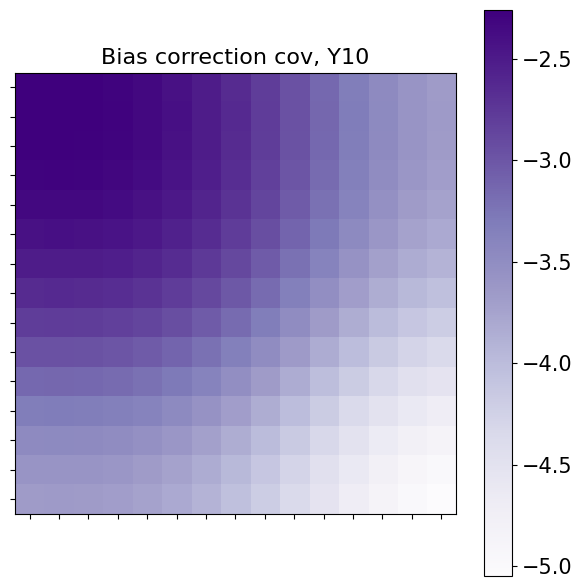

In [5]:
# Visualise the bias correlation covariance:

cmap = plt.get_cmap('Purples')
plt.figure(figsize=[6, 6])
plt.imshow(np.log10(Cb_cov_raw), cmap=cmap)

# Keep tick positions but remove labels
num_bins = len(rp_bin_c_raw[ind:])
tick_positions = np.arange(num_bins)

plt.xticks(tick_positions, [''] * num_bins, fontsize=15)
plt.yticks(tick_positions, [''] * num_bins, fontsize=15)

# Axis labels with units
#plt.xlabel(r"$r_p$ [$\mathrm{Mpc}/h$]", fontsize=16)
#plt.ylabel(r"$r_p$ [$\mathrm{Mpc}/h$]", fontsize=16)

# Colorbar
cbar2 = plt.colorbar()
cbar2.ax.tick_params(labelsize=15)
plt.title('Bias correction cov, Y10', fontsize=16)
plt.tight_layout()
#plt.savefig('../plots/EG_corr_LSSTY10_sims_vmin0.pdf')
plt.show()

Get data covariance matrix for E_G.

In [6]:
#Dcov_eg = egcov.get_egcov(params, rp_bin_edges, rp_bin_c, rp0, lens, src, Pimax, Nsamps, endfilename)
#np.savetxt('/home/danielle/Documents/CMU/Research/EG_comparison/txtfiles/Dcov_eg_'+endfilename+'.txt', Dcov_eg)
Dcov_eg_raw = np.loadtxt('../txtfiles/sim_eg_cov_Y10_addSN.dat')
Dcov_eg = Dcov_eg_raw[4:,4:]


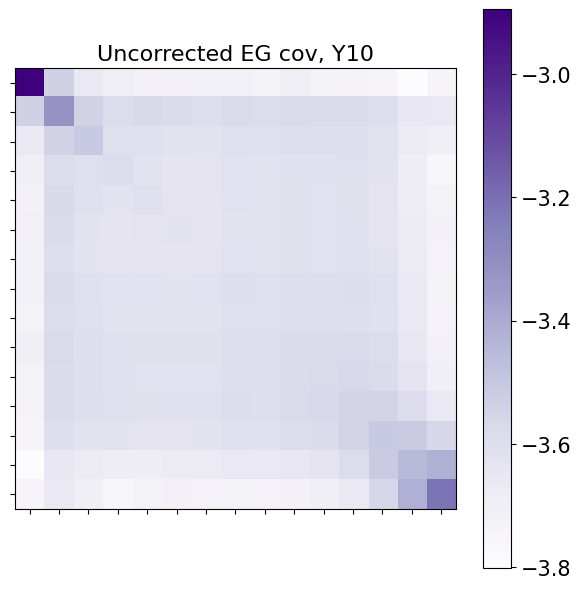

In [7]:
# Visualise the base eg covariance:

# Visualise the bias correlation covariance:

cmap = plt.get_cmap('Purples')
plt.figure(figsize=[6, 6])
plt.imshow(np.log10(Dcov_eg_raw), cmap=cmap)

# Keep tick positions but remove labels
num_bins = len(rp_bin_c_raw[ind:])
tick_positions = np.arange(num_bins)

plt.xticks(tick_positions, [''] * num_bins, fontsize=15)
plt.yticks(tick_positions, [''] * num_bins, fontsize=15)

# Axis labels with units
#plt.xlabel(r"$r_p$ [$\mathrm{Mpc}/h$]", fontsize=16)
#plt.ylabel(r"$r_p$ [$\mathrm{Mpc}/h$]", fontsize=16)

# Colorbar
cbar2 = plt.colorbar()
cbar2.ax.tick_params(labelsize=15)
plt.title('Uncorrected EG cov, Y10', fontsize=16)
plt.tight_layout()
#plt.savefig('../plots/EG_corr_LSSTY10_sims_vmin0.pdf')
plt.show()

Now combine the two to get the covariance for the corrected E_G.

In [8]:
cov_EG_corr= egcov.corrected_EG_cov(params, Dcov_eg_raw, Cb_cov_raw, rp_bin_edges_raw[ind:], rp_bin_c_raw[ind:], rp0, lens, src, Pimax, endfilename)

# Save this for use elsewhere
np.savetxt('../txtfiles/cov_EG_nLbiascorrected_Y10_simscov.dat', cov_EG_corr)

bias correction: getting Upgg
Warning, you selected a extrap_high that is less than k_max. Therefore no extrapolation will be done.
bias correction: getting Upgm
Warning, you selected a extrap_high that is less than k_max. Therefore no extrapolation will be done.
maxchi= 6669.353003473356
end of upsgm binned
getting Upgm
Warning, you selected a extrap_high that is less than k_max. Therefore no extrapolation will be done.
maxchi= 6669.353003473356
end of upsgm binned
getting Upgg
Warning, you selected a extrap_high that is less than k_max. Therefore no extrapolation will be done.


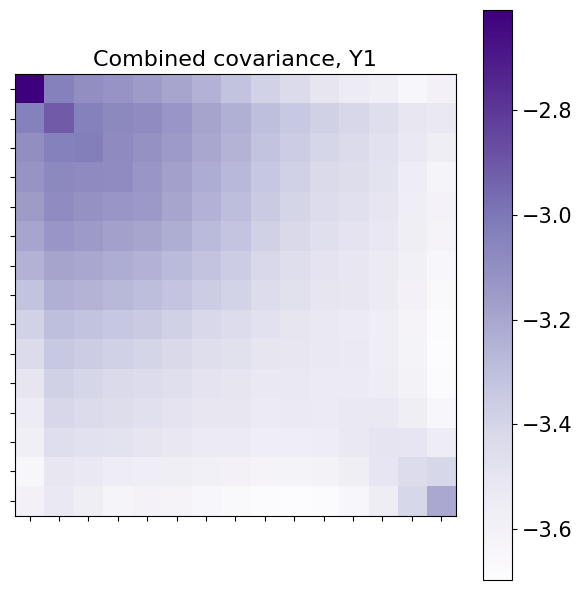

In [9]:
# Visualise the combined covariance

cmap = plt.get_cmap('Purples')
plt.figure(figsize=[6, 6])
plt.imshow(np.log10(cov_EG_corr), cmap=cmap)

# Keep tick positions but remove labels
num_bins = len(rp_bin_c_raw[ind:])
tick_positions = np.arange(num_bins)

plt.xticks(tick_positions, [''] * num_bins, fontsize=15)
plt.yticks(tick_positions, [''] * num_bins, fontsize=15)

# Axis labels with units
#plt.xlabel(r"$r_p$ [$\mathrm{Mpc}/h$]", fontsize=16)
#plt.ylabel(r"$r_p$ [$\mathrm{Mpc}/h$]", fontsize=16)

# Colorbar
cbar2 = plt.colorbar()
cbar2.ax.tick_params(labelsize=15)
plt.title('Combined covariance, Y1', fontsize=16)
plt.tight_layout()
#plt.savefig('../plots/EG_corr_LSSTY10_sims_vmin0.pdf')
plt.show()

In [10]:
# Get correlation matrix for combined covariance
corr_EG_corr = np.zeros_like(cov_EG_corr)
for i in range(0,15):
    for j in range(0,15):
        corr_EG_corr[i,j] = cov_EG_corr[i,j]/np.sqrt(cov_EG_corr[i,i]*cov_EG_corr[j,j])

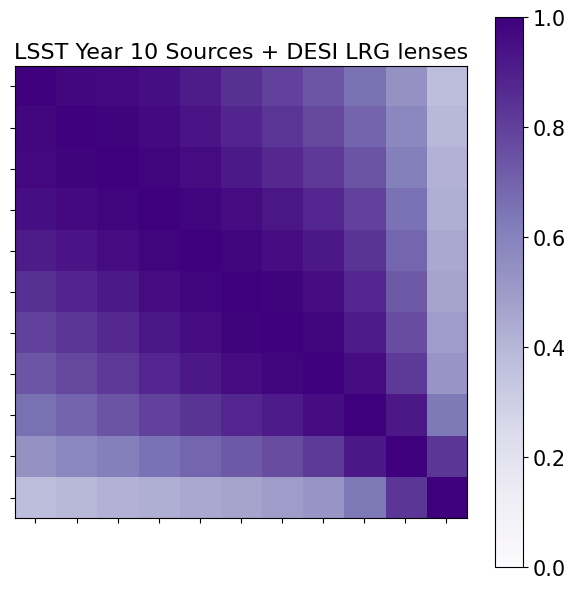

In [11]:
# Visualise the combined covariance

cmap = plt.get_cmap('Purples')
plt.figure(figsize=[6, 6])
plt.imshow(corr_EG_corr[4:,4:], cmap=cmap,vmin=0, vmax=1)

# Keep tick positions but remove labels
num_bins = len(rp_bin_c_raw[ind:][4:])
tick_positions = np.arange(num_bins)

plt.xticks(tick_positions, [''] * num_bins, fontsize=15)
plt.yticks(tick_positions, [''] * num_bins, fontsize=15)

# Axis labels with units
#plt.xlabel(r"$r_p$ [$\mathrm{Mpc}/h$]", fontsize=16)
#plt.ylabel(r"$r_p$ [$\mathrm{Mpc}/h$]", fontsize=16)

# Colorbar
cbar2 = plt.colorbar()
cbar2.ax.tick_params(labelsize=15)
plt.title('LSST Year 10 Sources + DESI LRG lenses', fontsize=16)
plt.tight_layout()
plt.savefig('../plots/EG_biascorrected_LSSTY10_sims.pdf')
plt.show()

Get the linear and nonlinear datavector for the bias-corrected E_G, at the mean values

In [12]:
# Get linear datavector - this has no correction because the correction is explicitly for nonlinear effects.
data_lin_EG = fid.E_G(params, rp_bin_edges, rp0, lens, src, Pimax, endfilename, nonlin=False)

getting Upgm
maxchi= 6669.353003473356
end of upsgm binned
getting Upgg


In [13]:
# First get C_b at the mean values.
C_b_mean = fid.bias_correction(params, rp_bin_edges, rp0, lens, src, Pimax, endfilename)

# Now get the corrected EG
data_nl_EG = fid.E_G_corrected(params, C_b_mean, rp_bin_edges, rp0, lens, src, Pimax, endfilename)

bias correction: getting Upgg
Warning, you selected a extrap_high that is less than k_max. Therefore no extrapolation will be done.
bias correction: getting Upgm
Warning, you selected a extrap_high that is less than k_max. Therefore no extrapolation will be done.
maxchi= 6669.353003473356
end of upsgm binned
getting Upgm
Warning, you selected a extrap_high that is less than k_max. Therefore no extrapolation will be done.
maxchi= 6669.353003473356
end of upsgm binned
getting Upgg
Warning, you selected a extrap_high that is less than k_max. Therefore no extrapolation will be done.


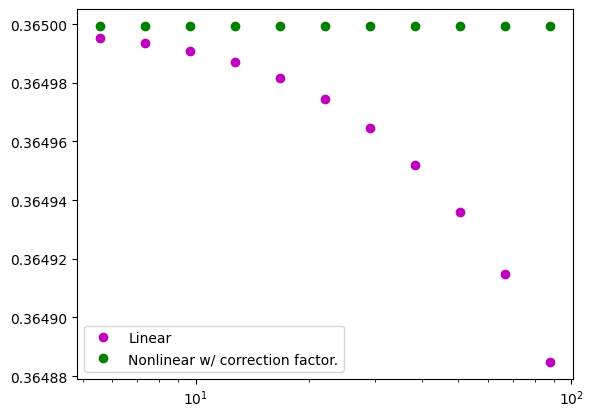

In [14]:
plt.figure()
plt.semilogx(rp_bin_c, data_lin_EG, 'mo', label='Linear')
plt.semilogx(rp_bin_c, data_nl_EG, 'go', label='Nonlinear w/ correction factor.')
plt.legend()
plt.show()  

chi2_in= 3.405629613147417e-05 , no cuts


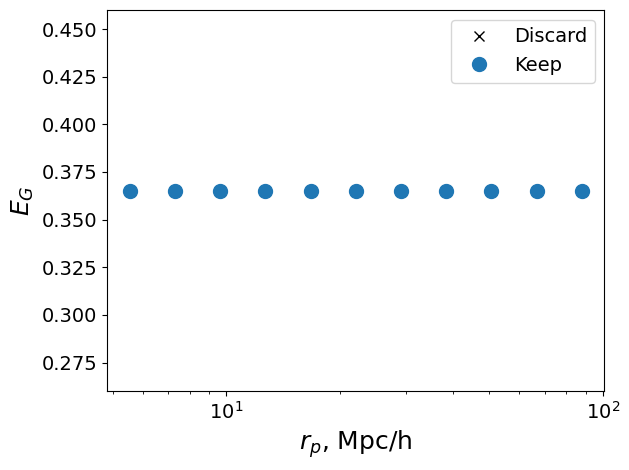

In [15]:
# Construct the hartlap factor

cut_inds_hold = u.linear_scale_cuts_hartlap(data_nl_EG, data_lin_EG, cov_EG_corr[4:,4:], rp_bin_c,covsamps=100)

ind_keep_Eg = [ind for ind in range(0,len(rp_bin_c)) if ind not in cut_inds_hold]
rp_keep_Eg = rp_bin_c[ind_keep_Eg]
Eg_keep = data_nl_EG[ind_keep_Eg]

plt.figure()
plt.semilogx(rp_bin_c, data_nl_EG, 'kx', markersize='7',label='Discard')
plt.semilogx(rp_keep_Eg, Eg_keep, 'o', markersize='10',label='Keep')
plt.ylabel('$E_G$',fontsize=18)
plt.xlabel('$r_p$, Mpc/h',fontsize=18)
plt.ylim(0.26,0.46)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=14)
plt.tight_layout()
#plt.savefig('../plots/EG_linearscales_nLbias_correction.pdf')
plt.show()


Get scale cuts for Eg

In [16]:
# Output the scale cuts in a readable format for later use.

cut = np.ones(len(rp_bin_c))
for i in range(0, len(rp_bin_c)):
    if i in cut_inds_hold:
        cut[i] = 0

print('cut bins Eg=', cut_inds_hold)
print('cut=', cut)

save_cuts = np.column_stack((rp_bin_c, cut))

np.savetxt('../txtfiles/scalecuts_nLbias_CORRECTIONFACTOR_KitanidisWhite2022_LSSTY10_simscov.dat', save_cuts, header='# rp bin centre,  cut this bin? 0 = Cut.')

cut bins Eg= []
cut= [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
